In [ ]:
!wget https://owncloud.charite.de/owncloud/index.php/s/zc9NTVJMw8AiuQn/download?path=%2F&files=20230611_export.h5 -O data.h5 -q

In [49]:
import h5py as h5
import numpy as np
from tqdm.auto import tqdm
from wholebrain import util,cluster,spatial,regression,stats
from matplotlib import pyplot as plt
import os
import matplotlib
import cupy as cp
from scipy.stats import pearsonr
from scipy.optimize import minimize
# TURN TQDM ON/OFF
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)



def binfcn(x):
    return np.nanmean(x), np.quantile(x,0.05), np.quantile(x,0.95)

In [28]:
pars={"corr_fc":
     {"do":True, "min_dist":400, "radius_list": [5,10,15,25,50,100,150,200], "save_full_at":[5,50,100,200],"dec_factor":20}
     } 

In [4]:
def load_dset(name):
    with h5.File('./data.h5','r') as fh5:
        return fh5[name]['coords'][:],fh5[name]['dff'][:],fh5[name]['traces'][:]

In [10]:
data={}
with h5.File('./data.h5','r') as fh5:
    names=[n for n in fh5.keys()]
    print('Datasets:', names)
   
p_out='tmp'
os.makedirs(os.path.join('./',p_out),exist_ok=True)

Datasets: ['dset_0', 'dset_1', 'dset_2', 'dset_3', 'dset_4', 'dset_5']


In [11]:
name=names[0]
coords,dff,traces=load_dset(name)
dff_mu=(dff-np.nanmean(dff,0,keepdims=True))[~np.isnan(dff.sum(1))] # Centered Data without NANs ( motion)

In [29]:
fh5_l.close()

In [31]:
fh5_l = h5.File(os.path.join(p_out, f"{name}_correlations.h5"), "w")
cc = stats.corrx(cp.array(dff_mu,'single'), cp.array(dff_mu,'single'))
pd = spatial.pdist(cp.array(coords,'single'), None)
fh5_l["ipsi_cc"], fh5_l["contra_cc"] = util.neighbourhood_correlation(
    coords, cc.get())
fh5_l["cc"] = cc.get()
fh5_l["pd"] = pd.get()
del cc,pd

 
fh5_l["fc_before"], fh5_l["fc_corr_mean"], fh5_l["fc_after"] = util.corr_fc( fh5_l["cc"][:], fh5_l["pd"][:], cp.array(dff_mu,'single'), **pars["corr_fc"])
fh5_l.close()


/home/hoffmmax/repos/hoffmann_et_al_2023/src/wholebrain/util.py:92: RuntimeWarning: invalid value encountered in divide
  ipsi_cc = np.sum((cc * mask_ipsi), axis=axis) / np.sum(mask_ipsi, axis=axis)
/home/hoffmmax/repos/hoffmann_et_al_2023/src/wholebrain/util.py:93: RuntimeWarning: invalid value encountered in divide
  contra_cc = np.sum((cc * mask_contra), axis=axis) / np.sum(mask_contra, axis=axis)


In [35]:
n_step=50
dist_bins = np.r_[10:1000:5]
binstats_list=[]

with h5.File(os.path.join(p_out, f"{name}_correlations.h5"),'r') as fh5:
    cc=fh5['cc'][:]
    pd=fh5['pd'][:]
    contra_cc=fh5['contra_cc'][:]
    ipsi_cc=fh5['ipsi_cc'][:]
    binstats = util.apply_to_bins(pd.ravel()[::n_step], dist_bins, cc.ravel()[::n_step], binfcn)
    binstats_list.append(binstats)
    print(fh5.keys())

<KeysViewHDF5 ['cc', 'contra_cc', 'fc_after', 'fc_before', 'fc_corr_mean', 'ipsi_cc', 'pd']>


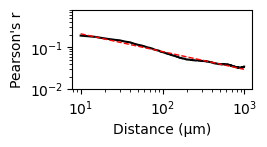

In [51]:
fig, ax = plt.subplots( figsize=(70/i2m, 40/i2m))
bin_ar=np.array(binstats_list)[:,:,0]
for ii,binstats in enumerate(binstats_list):
        xx=dist_bins[: - 1]
        yy=binstats[:, 0]
        powlaw= lambda x,a,k: a*xx**(k)
        mse= lambda a: np.sum((powlaw(xx,a[0],a[1])-yy)**2)
        a=minimize(mse,[yy.max(),-1])
        ax.plot(xx, yy, label=names[ii],c='k',lw=1,alpha=0.2)
        ax.plot(xx, powlaw(xx,*a.x).squeeze(),'--',c='r',lw=0.5,label='fit',alpha=0.2)
 
powlaw= lambda x,a,k: a*xx**(k)
yy=bin_ar.mean(0)
ax.plot(xx,yy,c='k') 
mse= lambda a: np.sum((powlaw(xx,a[0],a[1])-yy)**2)
a=minimize(mse,[yy.max(),-1])
ax.plot(xx, powlaw(xx,*a.x).squeeze(),'--',c='r',lw=1,label='fit')

    #ax.fill_between(dist_bins[1: - 1], binstats[1:, 1], binstats[1:, 2], label='5%-95%')
ax.set_ylim(0.01, 0.8)
#ax.set_xlim(None, 1500)
#ax.set_xticks((0,0.1,0.2,0.4))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Distance (µm)')
ax.set_ylabel("Pearson's r")
plt.tight_layout()


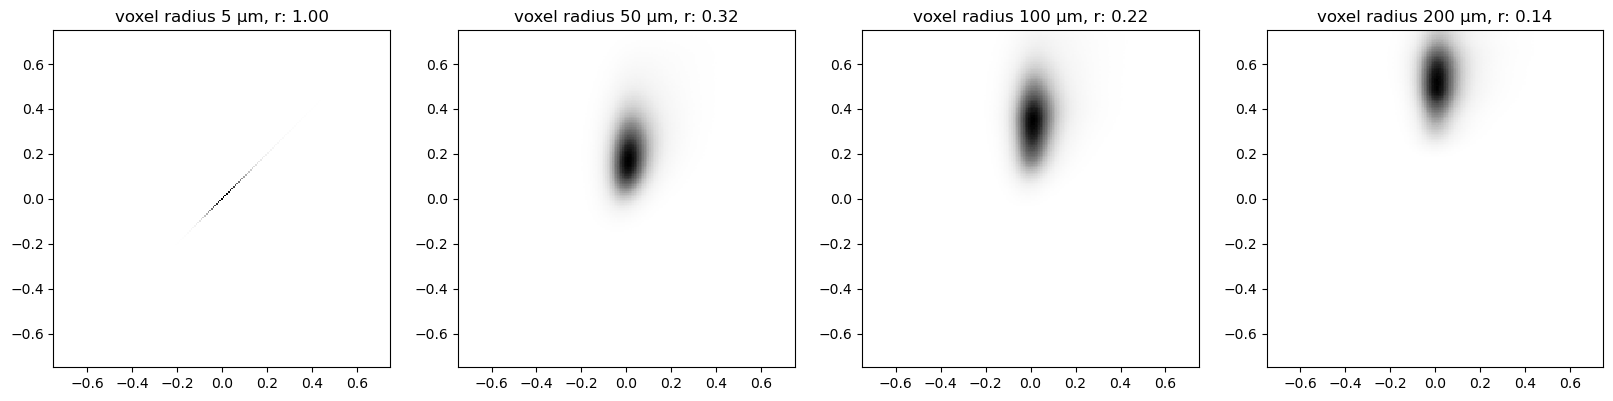

In [47]:
fig,axi=plt.subplots(1,4,figsize=[20,20])
with h5.File(os.path.join(p_out, f"{name}_correlations.h5"),'r') as fh5:
    for ii, s in enumerate(tqdm(pars['corr_fc']['save_full_at'])):
        x=fh5['fc_after'][ii]
        y=fh5['fc_before']
        r = pearsonr(x[~np.isnan(x)],y[~np.isnan(x)])
        axi[ii].hist2d(y, x,  bins=np.linspace(-.75,.75,200), cmap='Greys',rasterized=True);
        axi[ii].set_aspect('equal', 'box')
        ix=pars['corr_fc']['radius_list'].index(s)
        r_lbl=fh5['fc_corr_mean'][ix,0]
        axi[ii].set_title(f'voxel radius {s} µm, r: {r_lbl:.2f}')


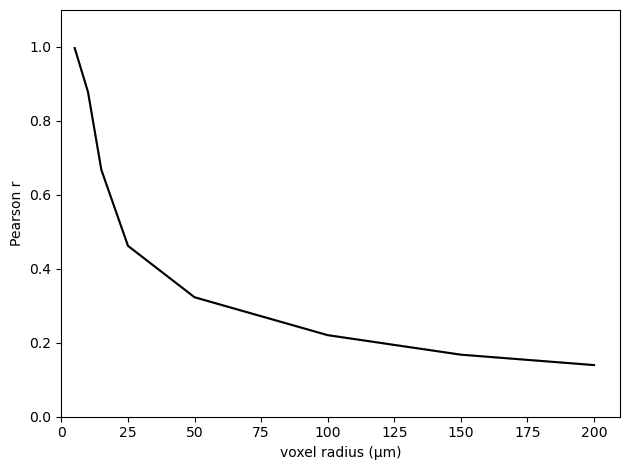

In [52]:
fig,ax=plt.subplots()
fc_l=[]



with h5.File(os.path.join(p_out, f"{name}_correlations.h5"),'r') as fh5:
        _=ax.plot(pars["corr_fc"]["radius_list"],fh5['fc_corr_mean'],label=name,c='k',alpha=0.2)
        fc_l.append(fh5['fc_corr_mean'][:])
ax.plot(pars['corr_fc']['radius_list'],np.array(fc_l).mean(0),'k',ls='-')
_=ax.set(xlim=(0,None), ylim=(0,1.1), xlabel='voxel radius (µm)', ylabel='Pearson r')
plt.tight_layout()
